<a href="https://colab.research.google.com/github/ainsleyfreedman01/pytorch-crash-course/blob/main/PyTorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Tutorial

References:
- https://playground.tensorflow.org/
- Quickstart: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
- Linear / fully-connected layers: https://pytorch.org/docs/main/nn.html#linear-layers
  - [`torch.nn.Linear`](https://pytorch.org/docs/main/generated/torch.nn.Linear.html)
- Activation functions: found in https://pytorch.org/docs/main/nn.functional.html
- Loss functions: https://pytorch.org/docs/main/nn.html#loss-functions
  - [`torch.nn.BCELoss`](https://pytorch.org/docs/main/generated/torch.nn.BCELoss.html)
  - [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/main/generated/torch.nn.CrossEntropyLoss.html)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [ ]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
#@title Run this code block to define plotting helper functions
#@markdown This defines `plot_boundary(X, pred)` which can plot the decision boundary of a neural network
from matplotlib import cm, ticker

MARKERS = ['o', 'v', '+']
COLORS = ['red', 'green', 'blue']
rgb_gradient_cmap = matplotlib.colors.ListedColormap(COLORS)
red_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("RedGradient", [(1, 0, 0, 0), (1, 0, 0, 1)])  # Transparent to red
green_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("GreenGradient", [(0, 1, 0, 0), (0, 1, 0, 1)])  # Transparent to green
blue_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BlueGradient", [(0, 0, 1, 0), (0, 0, 1, 1)])  # Transparent to blue

def plot_points(X, y):
    for i, label in enumerate(set(y)):
        points = X[y == label]
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

def predict(model, x):
    with torch.no_grad():
        o = net(torch.from_numpy(x).float())
    return o.numpy()

def plot_boundary(X, pred, num_classes=2):
    # Define grid limits based on current plot or data
    try:
        x_min, x_max = plt.gca().get_xlim()
        y_min, y_max = plt.gca().get_ylim()
    except:
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Generate mesh grid
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    xys = np.column_stack([xs.ravel(), ys.ravel()])

    # Make predictions over the grid points
    try:
        zs = pred(xys)
        if num_classes == 2:
            # Binary case: plot boundary based on probability threshold 0.5
            zs = zs.reshape(xs.shape)
            plt.contour(xs, ys, (zs >= 0.5).astype(int), colors='grey')
            plt.imshow(zs, cmap="PiYG", vmin=-0.2, vmax=1.2, alpha=0.4, origin='lower', extent=[x_min, x_max, y_min, y_max])
        else:
            # Multi-class case: color - gradient for each
            zzs = np.exp(zs) / np.sum(np.exp(zs), axis=1, keepdims=True)
            Z1 = zzs[:, 0].reshape(xs.shape)
            Z2 = zzs[:, 1].reshape(xs.shape)
            Z3 = zzs[:, 2].reshape(xs.shape)
            plt.imshow(Z1, cmap=red_cmap, origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])
            plt.imshow(Z2, cmap=green_cmap, origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])
            plt.imshow(Z3, cmap=blue_cmap, origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])

            # Multi-class case: boundary - take the argmax over classes
            zs = np.argmax(zs, axis=1).reshape(xs.shape)
            plt.contour(xs, ys, zs, levels=np.arange(num_classes), colors='grey')

            # plt.imshow(zs, cmap=rgb_gradient_cmap, alpha=0.4, origin='lower', extent=[x_min, x_max, y_min, y_max])

    except Exception as e:
        print(f"Error in plotting decision boundary: {e}")
        zs = pred(xys)
        plt.contour(xs, ys, zs.reshape(xs.shape), colors='grey')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Decision Boundary")

In [4]:
#@title Run this code block to define datasets
#@markdown - `D1(N)`: binary classificaiton, linear decision boundary
#@markdown - `D2(N)`: binary classificaiton, non-linear decision boundary
#@markdown - `D3(N)`: multiclass classification

class D1(Dataset):
    def __init__(self, N=50):
        super().__init__()
        rng = np.random.default_rng(0)
        self.X = np.r_[2.0 * rng.standard_normal((N//2, 2)) - [2, 2], 2.0 * rng.standard_normal((N//2, 2)) + [2, 2]]
        self.y = np.array([0] * (N//2) + [1] * (N//2))

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()

    def __len__(self):
        return len(self.X)


class D2(Dataset):
    def __init__(self, N=50):
        super().__init__()
        rng = np.random.default_rng(0)
        X = 3.0 * rng.standard_normal((N, 2))
        y = np.array([0] * N)
        y[np.diag(X@X.T)>10] = 1
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()

    def __len__(self):
        return len(self.X)


class D3(Dataset):
    def __init__(self, N=50):
        super().__init__()
        rng = np.random.default_rng(0)
        X = 3.0 * rng.standard_normal((N, 2))
        y = np.array([0] * N)
        y[np.diag(X@X.T) < 6] = 1
        y[(np.diag(X@X.T) >= 6) & (X@np.array([1,2]) >= 0)] = 2
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).long()

    def __len__(self):
        return len(self.X)

## Backprop demo

Linear regression with mean squared error loss

$$ \widehat{y} = w x + b, \; \; L = \frac{1}{2} (\widehat{y} - y)^2 $$

$$\frac{\partial L}{\partial w} = (\widehat{y} - y) x, \;\; \frac{\partial L}{\partial b} = (\widehat{y} - y)$$

We apply SGD with learning rate = 0.1
- Initialize $w = [0,0], b = 0$.
- The point we use to update is $x=[1,2], y=1$.
- $\widehat{y} = ?$, the updated $w = ?, b = ?$


In [ ]:
y_hat = wx + b = [0,0]*[1,2] + 0 = 0
dL/dw = -[1,2], dL/db = -1
w = [0,0] - 0.1 * (-[1,2]) = [0.1,0.2]
b = 0 - 0.1 * (-1) = 0.1

In [5]:
net = nn.Sequential(nn.Linear(2, 1))
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [6]:
# Initialize and clear gradients
nn.init.zeros_(net[0].weight)
nn.init.zeros_(net[0].bias)
try:
    net[0].weight.grad.zero_()
    net[0].bias.grad.zero_()
except:
    pass

print('Initial parameters')
print('w =', net[0].weight.data)
print('b =', net[0].bias.data)

# Forward pass
x = torch.tensor([1,2]).float()
y_true = torch.tensor([1]).float()
y_hat = net(x)  # <-- FILL IN THIS LINE
loss = 1/2 * F.mse_loss(y_hat, y_true)   # <-- FILL IN THIS LINE
print()
print('Forward pass')
print('y_hat =', y_hat.data)
print('loss. =', loss.data)

# Backward pass
loss.backward()          # <-- FILL IN THIS LINE
print()
print('Gradients')
print('dw =', net[0].weight.grad)
print('db =', net[0].bias.grad)

# Update
optimizer.step()         # <-- FILL IN THIS LINE
print()
print('Updated parameters')
print('w =', net[0].weight.data)
print('b =', net[0].bias.data)

Initial parameters
w = tensor([[0., 0.]])
b = tensor([0.])

Forward pass
y_hat = tensor([0.])
loss. = tensor(0.5000)

Gradients
dw = tensor([[-1., -2.]])
db = tensor([-1.])

Updated parameters
w = tensor([[0.1000, 0.2000]])
b = tensor([0.1000])


## Neural Net Training - Example (Logistic Regression)

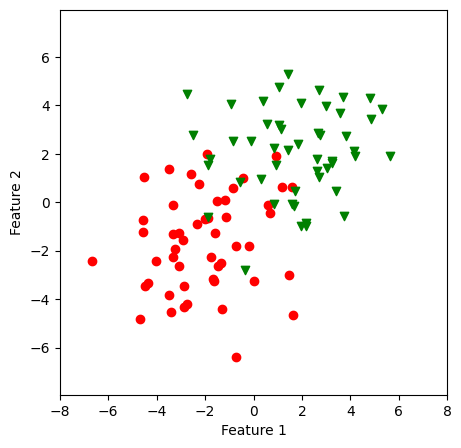

In [7]:
d1 = D1(100)
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

### Define the neural network

In [8]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: put neural net structure here
        self.fc = nn.Linear(2, 1) # 2 inputs, 1 output

    def forward(self, x):
        # TODO: define the forward pass here
        z = self.fc(x) # x is feature vector you pass in
        return torch.sigmoid(z)

In [9]:
torch.random.manual_seed(2)
net = Net1()

In [10]:
# How many float-valued parameters are there?
print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 3
Neural net architecture:
Net1(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


### Before training...

In [11]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

fc.weight 	 tensor([[ 0.1622, -0.1683]])
fc.bias 	 tensor([0.1939])


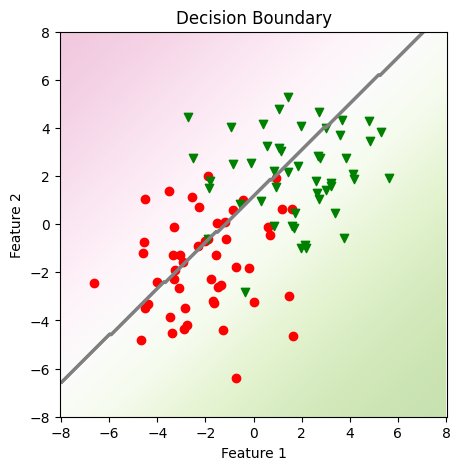

In [12]:
# Where is the decision boundary before training?
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d1.X, lambda x: predict(net, x))
plt.show()

### Train!

In [13]:
# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d1, batch_size=4)
criterion = nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [14]:
# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader: # taking a batch of training data from dataloader
        optimizer.zero_grad()
        y_hat = net(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step() # take a step in the SGD

100%|██████████| 1000/1000 [00:18<00:00, 53.39it/s]


### After training...

In [15]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

fc.weight 	 tensor([[0.8091, 0.9216]])
fc.bias 	 tensor([-0.0600])


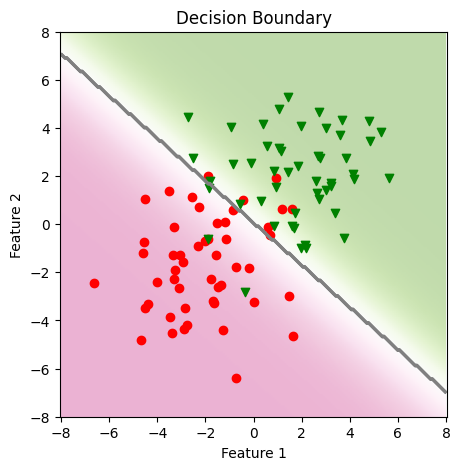

In [16]:
# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d1.X, lambda x: predict(net, x))
plt.show()

## Exercise Q2: non-linear decision boundary

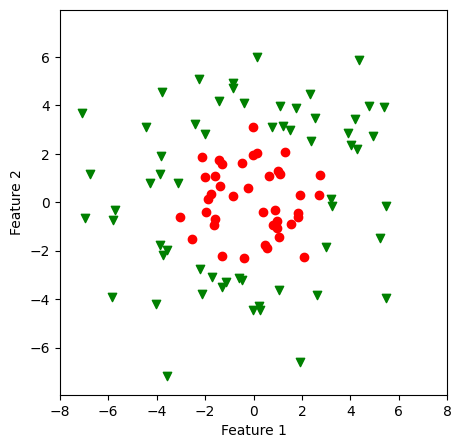

In [20]:
# Data
d2 = D2(100)
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

In [21]:
# Model
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: put neural net structure here
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 1)

    def forward(self, x):
        # TODO: define the forward pass here
        z = self.fc1(x)
        z = torch.tanh(z) # activation function
        z = self.fc2(z)
        return torch.sigmoid(z)

net = Net2()

print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 17
Neural net architecture:
Net2(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)


fc1.weight 	 tensor([[-0.5971, -0.2272],
        [ 0.0577,  0.1264],
        [-0.2024, -0.2348],
        [-0.3517, -0.2640]])
fc1.bias 	 tensor([-0.4811,  0.0536, -0.3298, -0.2054])
fc2.weight 	 tensor([[-0.4381, -0.1028,  0.2841, -0.2639]])
fc2.bias 	 tensor([0.1587])


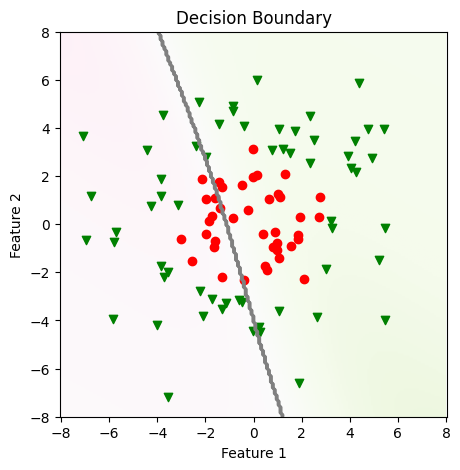

In [22]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary before training?
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d2.X, lambda x: predict(net, x))
plt.show()

In [23]:
# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d2, batch_size=4)
criterion = nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader: # taking a batch of training data from dataloader
        optimizer.zero_grad()
        y_hat = net(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step() # take a step in the SGD

100%|██████████| 1000/1000 [00:22<00:00, 43.56it/s]


fc1.weight 	 tensor([[-1.8135, -1.1964],
        [ 1.0656, -1.4104],
        [-0.8283, -0.0327],
        [-0.1490, -2.2702]])
fc1.bias 	 tensor([ 4.8013, -2.8245, -1.2770,  5.1406])
fc2.weight 	 tensor([[-4.4252,  7.6282,  8.3803, -6.4412]])
fc2.bias 	 tensor([12.4624])


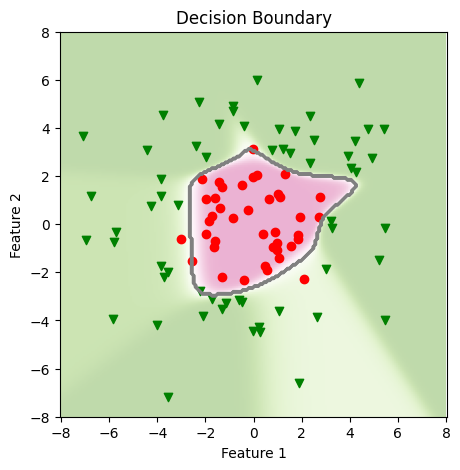

In [24]:
# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d2.X, lambda x: predict(net, x))
plt.show()

## Exercise Q3: three-way classification

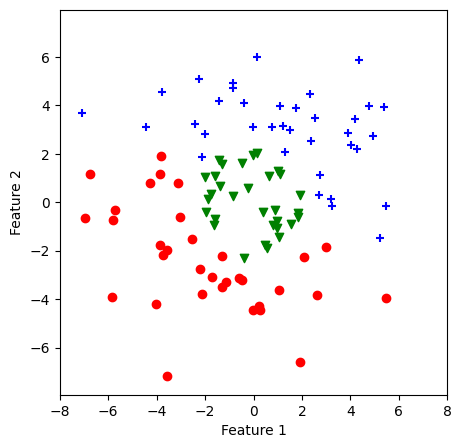

In [27]:
# Data...
d3 = D3(100)
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

In [25]:
# Model...
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: put neural net structure here
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 3)

    def forward(self, x):
        # TODO: define the forward pass here
        z = self.fc1(x)
        z = torch.tanh(z) # activation function
        z = self.fc2(z)
        return z

torch.random.manual_seed(1)
net = Net3()

print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 27
Neural net architecture:
Net3(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=3, bias=True)
)


fc1.weight 	 tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597]])
fc1.bias 	 tensor([ 0.0983, -0.0866,  0.1961,  0.0349])
fc2.weight 	 tensor([[ 0.1826, -0.1949, -0.0365, -0.0450],
        [ 0.0725, -0.0020,  0.4371,  0.1556],
        [-0.1862, -0.3020, -0.0838, -0.2157]])
fc2.bias 	 tensor([-0.1602,  0.0239,  0.2981])


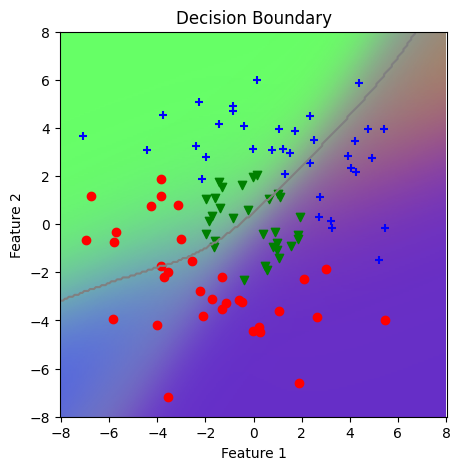

In [28]:
# Before training...

# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary before training?
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d3.X, lambda x: predict(net, x), num_classes=3)
plt.show()

In [29]:
# Train...

# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d3, batch_size=4)
criterion = nn.CrossEntropyLoss() # multiclass cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader: # taking a batch of training data from dataloader
        optimizer.zero_grad()
        y_hat = net(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step() # take a step in the SGD

100%|██████████| 1000/1000 [00:19<00:00, 50.47it/s]


fc1.weight 	 tensor([[-0.4290, -2.7274],
        [ 1.4368,  3.6681],
        [-2.3726,  1.0668],
        [ 2.7786,  1.7705]])
fc1.bias 	 tensor([ 6.4830, -0.9930,  5.4297,  6.5604])
fc2.weight 	 tensor([[ 2.6538, -2.9596, -2.9956, -5.5384],
        [ 1.3782, -1.8968,  4.8924,  3.9615],
        [-3.9631,  4.3575, -1.5799,  1.4718]])
fc2.bias 	 tensor([ 1.7682, -3.5667,  1.9603])


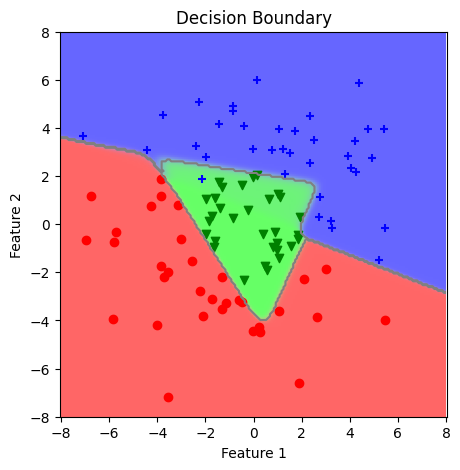

In [30]:
# After training...

# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d3.X, lambda x: predict(net, x), num_classes=3)
plt.show()

## Exercise Q4: Architecture Choices & Effects

In [31]:
# Model...
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: put neural net structure here
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 6)
        self.fc3 = nn.Linear(6, 8)
        self.fc4 = nn.Linear(8, 3)


    def forward(self, x):
        # TODO: define the forward pass here
        z = self.fc1(x)
        z = torch.tanh(z) # activation function
        z = self.fc2(z)
        z = torch.tanh(z) # activation function
        z = self.fc3(z)
        z = torch.tanh(z) # activation function
        z = self.fc4(z)
        return z

torch.random.manual_seed(1)
net = Net3()

print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 125
Neural net architecture:
Net3(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=6, bias=True)
  (fc3): Linear(in_features=6, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=3, bias=True)
)


In [32]:
# Train...

# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d3, batch_size=4)
criterion = nn.CrossEntropyLoss() # multiclass cross entropy loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader: # taking a batch of training data from dataloader
        optimizer.zero_grad()
        y_hat = net(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step() # take a step in the SGD

100%|██████████| 1000/1000 [00:24<00:00, 40.84it/s]


fc1.weight 	 tensor([[ 0.3702, -3.0574],
        [ 1.7757,  3.8638],
        [-1.9012,  0.7024],
        [ 2.3850,  1.6107]])
fc1.bias 	 tensor([ 5.7402, -1.0012,  3.3691,  5.2253])
fc2.weight 	 tensor([[ 2.5522, -1.4369,  2.9782,  0.3773],
        [ 1.5156,  0.0982,  1.6193,  1.2038],
        [-0.1883, -1.2205, -2.2665, -1.8959],
        [-3.0284,  1.6754, -0.7186,  0.3376],
        [ 0.4071, -0.8628, -0.0740,  2.6439],
        [ 0.0732, -0.5530, -1.1552, -0.8176]])
fc2.bias 	 tensor([ 0.1516, -1.8493, -0.1983,  0.2850,  0.1270, -0.1955])
fc3.weight 	 tensor([[ 0.4250,  0.8873, -0.7290,  0.3745,  0.9921, -0.2662],
        [-0.7138,  0.2754, -0.7829, -0.1110,  1.1383, -0.2668],
        [ 2.1216,  0.9928, -0.6377, -0.0720,  0.2088, -0.3296],
        [-0.6202,  0.1572, -0.0227,  1.6224,  0.0728, -0.3807],
        [ 0.0601,  0.1574,  0.1143, -1.4252,  0.4039,  0.3510],
        [ 1.6335,  0.6289, -0.3377, -0.1515,  0.2855, -0.1669],
        [-0.8635,  0.8203, -1.3156, -0.0043,  1.1826, -0.

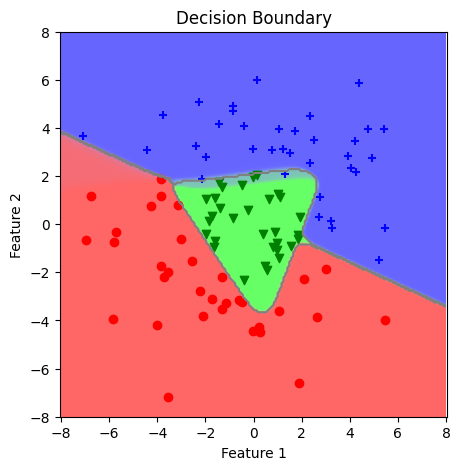

In [33]:
# After training...

# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d3.X, lambda x: predict(net, x), num_classes=3)
plt.show()